<a href="https://colab.research.google.com/github/Murcha1990/AppliedDS_DPO_2024/blob/main/Lesson4_NLP4/07_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 7: Large Language Models

In [ ]:
%pip install --quiet bitsandbytes==0.41.1 transformers==4.39.3 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2 torchmetrics

import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import bitsandbytes as bnb
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from IPython.display import clear_output
from random import sample
from tqdm import tqdm
from torchmetrics.functional import accuracy
from torch.optim import AdamW
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig

sns.set_theme()

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Closed-Source модели

Сейчас все основные SoTA-решения являются Closed-Source, и доступны только через веб-интерфейс, или через API с жесткими ограничениями. Удобно, если нужно прогнать несколько вопросов - попробуйте сами.


- OpenAI API (через VPN) - [openai.com/api](https://openai.com/api/)
- Chatbot Arena (удобный способ попробовать топовые LLMки, но с очень строгими ограничениями) - [chat.lmsys.org](https://chat.lmsys.org)
- YandexGPT 3 (отличный вариант для русскоязычных текстов) - [console.yandex.cloud](https://console.cloud.yandex.ru/link/yandexgpt/chat)


Но в демо-режиме особо не разгонишься, и ничего не автоматизируешь. Для масштабного применения придется платить за доступ к API. Как быть, если хотим классные модели, но бесплатно?

## Open-Source модели

К счастью, тут спасают модели с открытым исходным кодом. Удобнее всего их искать на [HuggingFace](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending) или на уже упомянутом [ChatBot Arena](https://chat.lmsys.org) - во вкладке LeaderBoard искать модели с открытыми лицензиями. Примеры:



-   [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)
-   [Mixtral-8x7B-Instruct](https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1)
-   [OpenChat-3.5](https://huggingface.co/openchat/openchat-3.5-0106)



### Загрузка модели

Давайте попробуем подгрузить и использовать такую модель. Сразу предупреждаю - мы будем мучать GPU, беспощадно. Не забудьте поставить GPU в среде выполнения.

In [ ]:
!nvidia-smi

Sat May 25 07:14:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

https://huggingface.co/openchat/openchat-3.5-0106

In [ ]:
model_name = 'openchat/openchat-3.5-0106'

tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Можем заметить, что мы уже заняли 13 ГБ из доступных 15. Далее действовать нужно очень осторожно.

In [ ]:
!nvidia-smi

Sat May 25 07:36:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              27W /  70W |  12977MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Генерация

Вспомним, что под капотом это все еще просто генеративная модель, которая предсказывает вероятности следующих токенов. Что делать с этими вероятностями дальше - можно определить с помощью стратегии генерации.

| Стратегия | Описание | Плюсы и минусы |
| --- | --- | --- |
| Greedy Search | Выбирает слово с наивысшей вероятностью как следующее слово в последовательности. | Плюсы: Простота и скорость.<br> Минусы: Может привести к повторяющемуся и несвязному тексту. |
| Семплинг с температурой | Добавляет случайность в выбор слова. Большая температура приводит к большей случайности. | Плюсы: Позволяет исследовать и получать разнообразный результат.<br> Минусы: Высокие температуры могут привести к бессмысленным результатам. |
| Семплинг по ядру (Top-p семплинг) | Выбирает следующее слово из усеченного словаря, "ядра" слов, которые имеют суммарную вероятность, превышающую предустановленный порог (p). | Плюсы: Обеспечивает баланс между разнообразием и качеством.<br> Минусы: Настройка оптимального 'p' может быть затруднительна. |
| Beam Search | Исследует множество гипотез (последовательностей слов) на каждом шаге и сохраняет 'k' наиболее вероятных, где 'k' - ширина луча. | Плюсы: Дает более надежные результаты, чем жадный поиск.<br> Минусы: Может страдать от нехватки разнообразия и приводить к общим ответам. |
| Top-k семплинг | Случайным образом выбирает следующее слово из 'k' слов с самыми высокими вероятностями. | Плюсы: Вводит случайность, увеличивая разнообразие результатов.<br> Минусы: Случайный выбор иногда может привести к менее связному тексту. |
| Нормализация длины | Предотвращает предпочтение модели более коротких последовательностей за счет деления логарифмированных вероятностей на длину последовательности, возведенную в некоторую степень. | Плюсы: Делает более длинные и потенциально более информативные последовательности более вероятными.<br> Минусы: Настройка фактора нормализации может быть сложной. |
| Стохастический Beam Search | Вводит случайность в процесс выбора 'k' гипотез в поиске пучком. | Плюсы: Увеличивает разнообразие в сгенерированном тексте.<br> Минусы: Баланс между разнообразием и качеством может быть сложно управлять. |
| Декодирование с минимальным риском Байеса (MBR) | Выбирает гипотезу (из многих), которая минимизирует ожидаемую потерю для функции потерь. | Плюсы: Оптимизирует результат в соответствии с определенной функцией потерь.<br> Минусы: Вычислительно более сложно и требует хорошо подобранную функциию потерь. |

Референсы:
- [Документация `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [Документация `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- [Статья о стратегиях генерации на Huggingface](https://huggingface.co/docs/transformers/generation_strategies)

In [ ]:
# prompt = 'The first discovered martian lifeform looks like'
prompt = 'Расскажи как работает адронный коллайдер. Напиши ответ на русском языке.'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
print("Input batch (encoded):", batch)

Input batch (encoded): {'input_ids': tensor([[    1,  7543, 28788,  3948,  3139,  8600, 26726,  2734, 16833, 11197,
          4086,  1619, 26593, 28819, 11078, 28723,  3760,  2749,  3107,  2433,
          8496,   929, 24379,  9330, 23980,  4026, 28723]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


Greedy Search

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=False)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>Расскажи как работает адронный коллайдер. Напиши ответ на русском языке.

Адронный коллайдер - это ускоритель частиц, который используется для исследования фундаментальных свойств материи. Он состоит из двух кругов, в которых ускоряются заряженные частицы до


Семплинг с температурой

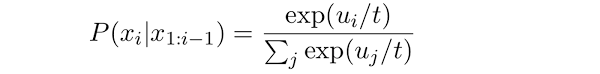

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.2)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>The first discovered martian lifeform looks like a cross between a jellyfish and a sponge.

The discovery was made by a team of researchers from the University of Edinburgh and the European Space Agency.

The researchers used a robotic arm to scoop up a sample of the Martian soil and then analyzed it using a mass spectrom


Top-K семплинг

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.1, top_k=10)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>The first discovered martian lifeform looks like a cross between a jellyfish and a squid.

The discovery was made by a team of scientists from the University of Edinburgh, who used a robotic arm to collect samples from a Martian lake bed.

The researchers found the remains of a small, translucent organism, which they


Beam Search

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=False, num_beams=3)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>The first discovered martian lifeform looks like a cross between an earthworm and a caterpillar.

The discovery was made by a team of scientists from the University of California, Berkeley, who were studying images taken by NASA's Mars rover, Curiosity.

The researchers identified the creature in a rock sample that Curios


### Создание промпта

Изначально модели заточены на генерацию - чтобы общаться с ними в привычном режиме диалога промпт нужно отформатировать. Правильный формат обычно указан в документации модели, но для некоторых моделей его можно восстановить с помощью метода apply_chat_template

In [ ]:
messages = [
    {"role": "user", "content": "What is your favourite condiment?"},
    {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
    {"role": "user", "content": "Do you have mayonnaise recipes?"}
]


In [ ]:
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [ ]:
prompt

"<s>GPT4 Correct User: What is your favourite condiment?<|end_of_turn|>GPT4 Correct Assistant: Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!<|end_of_turn|>GPT4 Correct User: Do you have mayonnaise recipes?<|end_of_turn|>GPT4 Correct Assistant:"

In [ ]:
inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(device)
output_tokens = model.generate(inputs, do_sample=True, temperature=0.7, max_new_tokens=256)
print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>GPT4 Correct User: What is your favourite condiment? <|end_of_turn|> GPT4 Correct Assistant: Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen! <|end_of_turn|> GPT4 Correct User: Do you have mayonnaise recipes? <|end_of_turn|> GPT4 Correct Assistant: Absolutely! Here's a simple recipe for homemade mayonnaise:

Ingredients:
- 1 large egg yolk, at room temperature
- 1 teaspoon Dijon mustard
- 1 tablespoon white wine vinegar or lemon juice
- 1 teaspoon salt
- 1/2 teaspoon ground black pepper
- 1 cup vegetable oil or light olive oil

Instructions:
1. In a medium bowl, whisk together the egg yolk, mustard, vinegar, salt, and pepper until well combined.
2. Slowly drizzle in the oil while continuously whisking. Start with a few drops and gradually increase the flow of oil. The key is to add the oil very slowly so that the egg yolk emulsifies with the oil and creates a thick, crea

У OpenChat есть два варианта ассистента - дефолтный, которыйы реализуется с помощью apply_chat_template, и математический - для его использования нужно использовать имена Math Correct User и Math Correct Assistant.

In [ ]:
messages = [
    {"role": "user", "content": "10.3 − 7988.8133="}
]

prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True).replace('GPT4', 'Math')

print(prompt)

<s>Math Correct User: 10.3 − 7988.8133=<|end_of_turn|>Math Correct Assistant:


### Chain-of-Thought Reasoning

https://www.promptingguide.ai/techniques/cot

Для оптимальных промптов модели необходимо давать не только примеры ответов, но и снабжать эти примеры детально описанным процессом того, как прийти к этому результату - и при генерации требовать от модели того же.

In [ ]:
prompt = """
<s>GPT4 Correct User:
Question: The original retail price of an appliance was 60 percent more than its wholesale cost. If the appliance was actually sold for 20 percent less than the original retail price, then it was sold for what percent more than its wholesale cost?
Answer Choices: (A) 20% (B) 28% (C) 36% (D) 40% (E) 42% <|end_of_turn|>
GPT4 Correct Assistant:
Rationale: wholesale cost = 100;\noriginal price = 100*1.6 = 160;\nactual price = 160*0.8 = 128.\nAnswer: B.
Correct Answer: B <|end_of_turn|>


GPT4 Correct User:
Question: A grocer makes a 25% profit on the selling price for each bag of flour it sells. If he sells each bag for $100 and makes $3,000 in profit, how many bags did he sell?
Answer Choices: (A) 12 (B) 16 (C) 24 (D) 30 (E) 40 <|end_of_turn|>
GPT4 Correct Assistant:
Rationale: Profit on one bag: 100*1.25= 125\nNumber of bags sold = 3000/125 = 24\nAnswer is C.
Correct Answer: C <|end_of_turn|>


GPT4 Correct User:
Question: 20 marbles were pulled out of a bag of only white marbles, painted black, and then put back in. Then, another 20 marbles were pulled out, of which 1 was black, after which they were all returned to the bag. If the percentage of black marbles pulled out the second time represents their percentage in the bag, how many marbles in total Q does the bag currently hold?
Answer Choices: (A) 40 (B) 200 (C) 380 (D) 400 (E) 3200
GPT4 Correct Assistant:
Rationale: We know that there are 20 black marbles in the bag and this number represent 1/20 th of the number of all marbles in the bag, thus there are total Q of 20*20=400 marbles.\nAnswer: D.
Correct Answer: D <|end_of_turn|>


GPT4 Correct User: Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
GPT4 Correct Assistant:
Rationale:
""".strip()

In [ ]:
inputs =  tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
output_tokens = model.generate(**inputs, do_sample=True, temperature=0.9, max_new_tokens=512)
print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s><s>GPT4 Correct User:
Question: The original retail price of an appliance was 60 percent more than its wholesale cost. If the appliance was actually sold for 20 percent less than the original retail price, then it was sold for what percent more than its wholesale cost?
Answer Choices: (A) 20% (B) 28% (C) 36% (D) 40% (E) 42%  <|end_of_turn|> 
GPT4 Correct Assistant:
Rationale: wholesale cost = 100;
original price = 100*1.6 = 160;
actual price = 160*0.8 = 128.
Answer: B.
Correct Answer: B  <|end_of_turn|> 


GPT4 Correct User:
Question: A grocer makes a 25% profit on the selling price for each bag of flour it sells. If he sells each bag for $100 and makes $3,000 in profit, how many bags did he sell?
Answer Choices: (A) 12 (B) 16 (C) 24 (D) 30 (E) 40  <|end_of_turn|> 
GPT4 Correct Assistant:
Rationale: Profit on one bag: 100*1.25= 125
Number of bags sold = 3000/125 = 24
Answer is C.
Correct Answer: C  <|end_of_turn|> 


GPT4 Correct User:
Question: 20 marbles were pulled out o

In [ ]:
torch.cuda.empty_cache()
gc.collect()

44

## Использование квантизированных моделей

Если мы жестко ограничены в ресурсах, в частности, в памяти (как в колабе), бывает полезно использовать квантизированную модель. Например, с текущими мощностями подгрузить модель Mistral-7B-Instruct-v0.2 в ее исходном виде бы не получилось. Но мы можем квантизировать ее до 8 битов, и использовать так.

* `load_in_8bit` (bool, optional, defaults to False) — This flag is used to enable 8-bit quantization with LLM.int8().

* `llm_int8_threshold` (float, optional, defaults to 6.0) — This corresponds to the outlier threshold for outlier detection as described in LLM.int8() : 8-bit Matrix Multiplication for Transformers at Scale paper: https://arxiv.org/abs/2208.07339 Any hidden states value that is above this threshold will be considered an outlier and the operation on those values will be done in fp16. Values are usually normally distributed, that is, most values are in the range [-3.5, 3.5], but there are some exceptional systematic outliers that are very differently distributed for large models. These outliers are often in the interval [-60, -6] or [6, 60]. Int8 quantization works well for values of magnitude ~5, but beyond that, there is a significant performance penalty. A good default threshold is 6, but a lower threshold might be needed for more unstable models (small models, fine-tuning).

In [ ]:
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'

tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.,
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
    quantization_config=quantization_config,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: Can't load tokenizer for 'mistralai/Mistral-7B-Instruct-v0.2'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'mistralai/Mistral-7B-Instruct-v0.2' is the correct path to a directory containing all relevant files for a LlamaTokenizer tokenizer.

In [ ]:
prompt = 'The first discovered martian lifeform looks like'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
print("Input batch (encoded):", batch)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=False)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Input batch (encoded): {'input_ids': tensor([[    1,   415,   907,  8324, 15370,   753,  1411,   674,  4674,   737]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Output: <s>The first discovered martian lifeform looks like a cross between a spider and a jellyfish.

The discovery was made by a team of scientists from the University of California, Berkeley, and the University of Washington, who analyzed images of Martian rocks taken by NASA's Curiosity rover.

The researchers identified the fossilized


## Parameter-Efficient Finetuning

Теперь попробуем дообучить модель GPT2-small на задачу анализа тональности с помощью различных методов PEFT:

- LoRa – Low-Rank Adaptation
- Prompt tuning
- PEFT + LP-FT

### LoRA

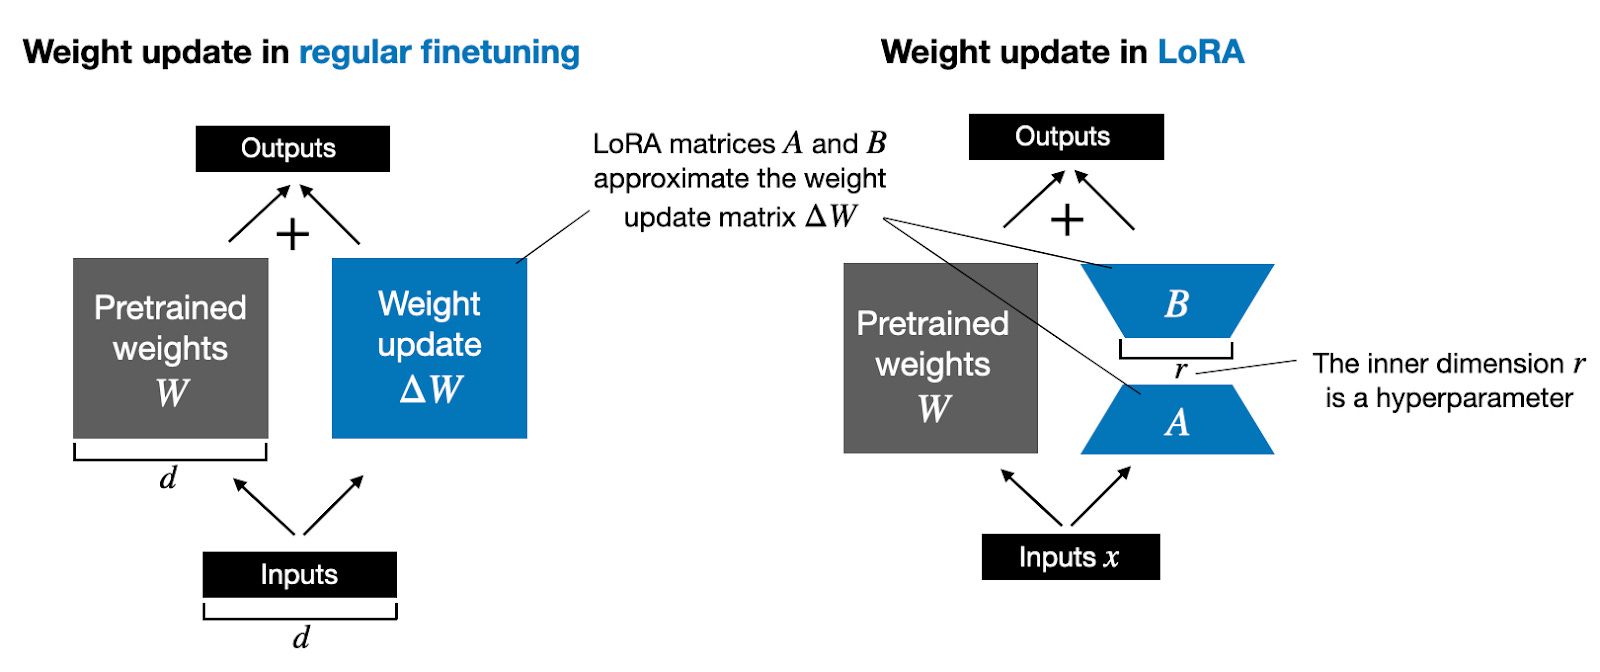

In [ ]:
train_dataset = load_dataset("glue", "sst2", split='train[:50000]')
valid_dataset = load_dataset("glue", "sst2", split="validation")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

### Инициализация токенизатора и модели

In [ ]:
model_checkpoint = "gpt2"

In [ ]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [ ]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_classes)
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs):
        out = self.model.transformer(
            input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).last_hidden_state
        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]
        return self.model.score(out)

    @property
    def device(self):
        return next(self.model.parameters()).device


num_classes = 2
model = Model(tokenizer, num_classes)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sum(p.numel() for p in model.parameters())

124442112

### Проверка токенизатора

In [ ]:
tokenizer(train_dataset[0]["sentence"])

{'input_ids': [24717, 649, 3200, 507, 422, 262, 21694, 4991, 220], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

In [ ]:
print("       0       1")
classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

       0       1
Train: 0.442 0.558
Valid: 0.491 0.509


### Объявление функции для обучения моделей

In [ ]:
_ = model.to(device)

In [ ]:
def training_loop_fn(model, opt, total_num_iters, eval_freq, train_loader, valid_loader):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["sentence"], padding=True, return_tensors='pt')
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
            targets = batch["label"].to(device)
            loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets, task="binary")

            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))

            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))

                model.train()

            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()

                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["sentence"], padding=True, return_tensors='pt')
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num
        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]

        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device), task='binary')

    return loss_epoch / num_epoch, acc.item()

### Fine-tuning

Обучаем все веса модели. Данный подход будет наиболее требовательным к памяти, однако он применяется чаще всего.

In [ ]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


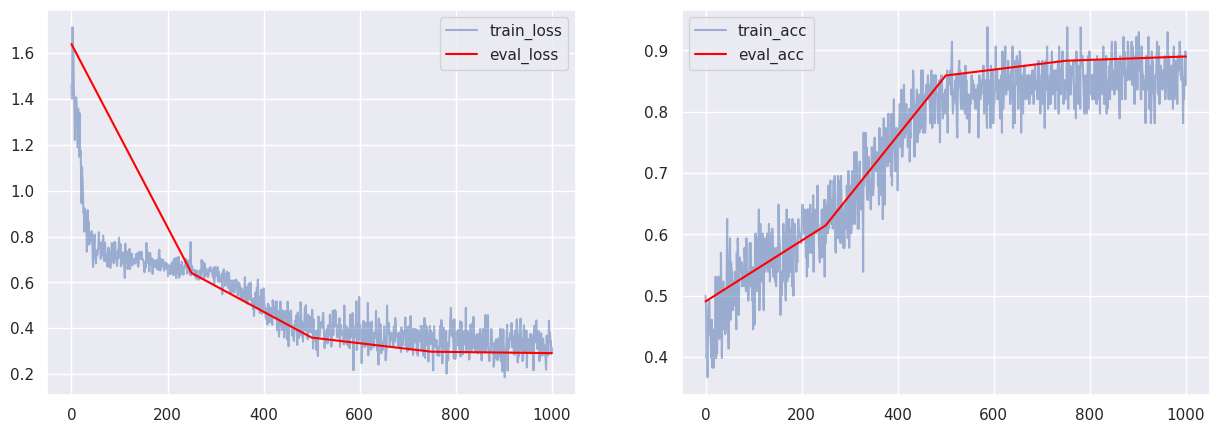

 56%|█████▌    | 218/391 [01:39<01:18,  2.19it/s]

CPU times: user 7min 26s, sys: 4.04 s, total: 7min 30s
Wall time: 7min 37s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2913247204701835
val accuracy: 0.8899082541465759


### Linear Probing

Учим только последний линейный слой (голову) модели.

In [ ]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.model.score.parameters(), lr=1e-4)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


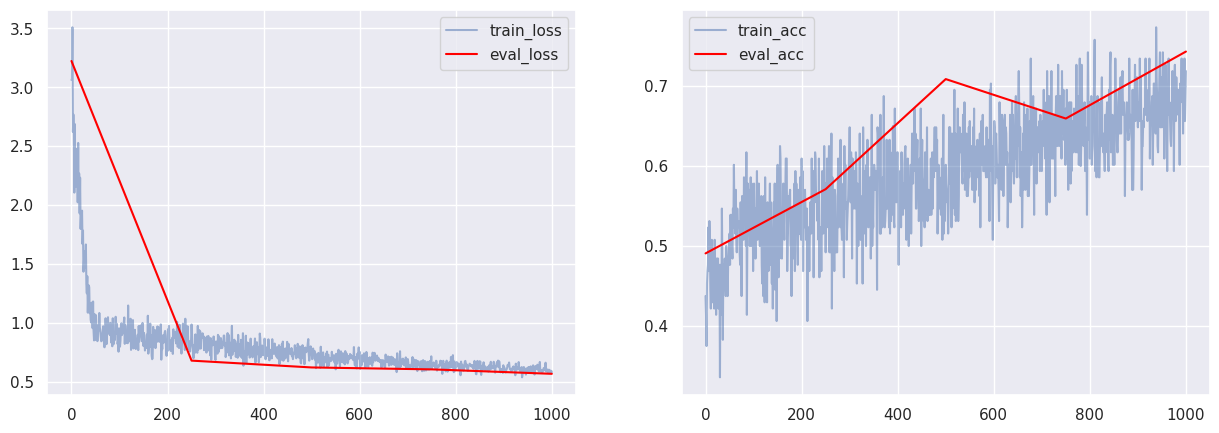

 56%|█████▌    | 218/391 [01:32<01:13,  2.36it/s]

CPU times: user 6min 52s, sys: 3.55 s, total: 6min 56s
Wall time: 7min


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.5663211367545872
val accuracy: 0.7431192398071289


### LoRa

В оригинальной статье авторы предлагают учить только матрицы $W_K$ и $W_V$ в слоях внимания трансформера и последний линейный слой. Однако мы добавим к ним еще матрицу $W_Q$, потому что в архитектуре GPT все три матрицы считаются с помощью одного слоя, и разделять их было бы слишком неудобно.

![image-2.png](attachment:image-2.png)

Для реализации Parameter-Efficient Fine-Tuning мы будем пользоваться библиотекой `peft` (семейство huggingface). В ней реализованы многие наиболее удачные способы дообучения моделей. Полный список можно найти [тут](https://github.com/huggingface/peft).

Самый важный параметр этой модели – ранг матриц $A$ и $B$ ($r$). Его увеличение дает больше степеней свободы в настройке добавки $AB$, повышая вместе с этим количество обучаемых параметров.

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_dropout=0.1, target_modules=['c_attn']
)

model = Model(tokenizer, num_classes).to(device)
lora_model = get_peft_model(model, peft_config).to(device)
lora_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,448 || all params: 124,738,560 || trainable%: 0.23765546115010466


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1059: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

296448

In [ ]:
optimizer = AdamW(lora_model.parameters(), lr=1e-4)

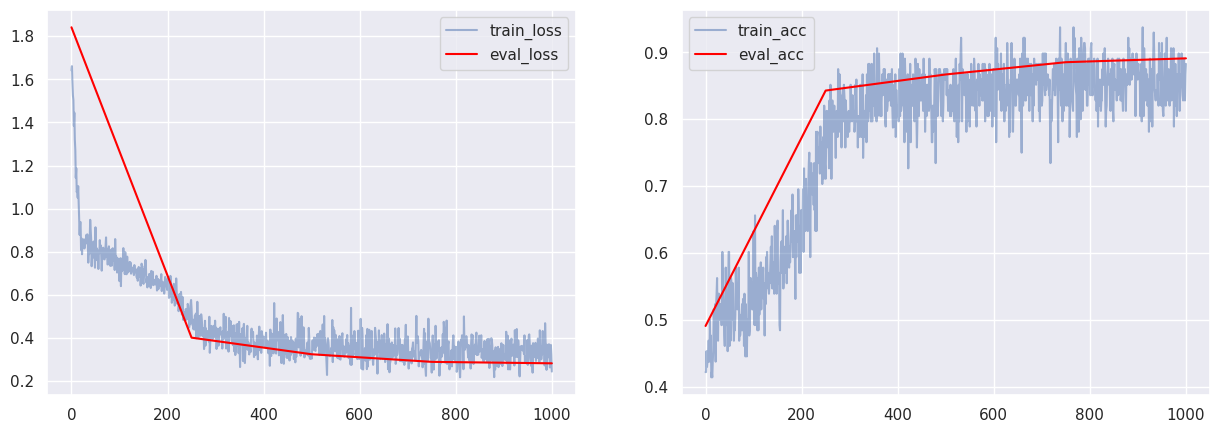

 56%|█████▌    | 218/391 [01:27<01:09,  2.49it/s]

CPU times: user 6min 27s, sys: 3.49 s, total: 6min 31s
Wall time: 6min 35s


In [ ]:
%%time
training_loop_fn(lora_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(lora_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.28246846330275227
val accuracy: 0.8910550475120544


In [ ]:
torch.save(lora_model.base_model.model.model.score.state_dict(), 'lora_head.pt')

### Prompt Tuning

Prompt Tuning – наиболее архитектурно-зависимый способ дообучения моделей, так как основан на наблюдении о том, что большие языковые модели способны решать задачи в zero-shot и few-shot парадигме (то есть опираясь только на входной промпт и текст, для которого нужно выдать ответ). Для моделей, которые могут работать в таком формате Prompt Tuning предлагает не выбирать промпт руками, а обучить его. Таким образом, этот метод лучше всего будет работать с моделями вида GPT и хуже всего с BERT. Вместе с промптом дополнительно доучивается голова.

<!-- <img src="attachment:60eae4f0-193d-4108-b9c2-8d37e54f791e.png" alt="drawing" width="800"/> -->
![image](attachment:60eae4f0-193d-4108-b9c2-8d37e54f791e.png)


При настройке промпта можно варьировать его длину, а так же способ инициализации. Тут работает правило: чем больше датасет для дообучения, тем длиннее можно брать промпты. Если датасет маленький, то длиный промпт не сможет обучиться.

In [ ]:
len(tokenizer("Predict if sentiment of this review is positive or negative")['input_ids'])

11

In [ ]:
init = {PromptTuningInit.TEXT: "Predict if sentiment of this review is positive or negative"}

In [ ]:
config = model.config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, num_virtual_tokens=12,
    num_layers=config.n_layer, token_dim=config.n_embd, num_attention_heads=config.n_head,
    prompt_tuning_init=init
)

model = Model(tokenizer, num_classes).to(device)
pt_model = get_peft_model(model, peft_config).to(device)
pt_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 10,752 || all params: 124,452,864 || trainable%: 0.008639415481832544


In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

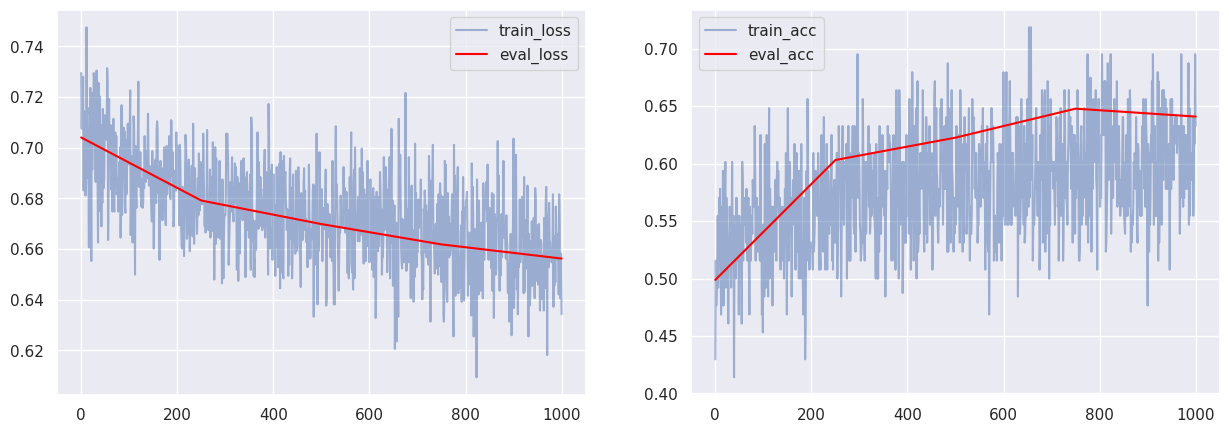

 56%|█████▌    | 218/391 [01:43<01:22,  2.10it/s]

CPU times: user 7min 31s, sys: 3.69 s, total: 7min 35s
Wall time: 7min 43s


In [ ]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.6562589592889908
val acc: 0.6410550475120544


### LP-FT

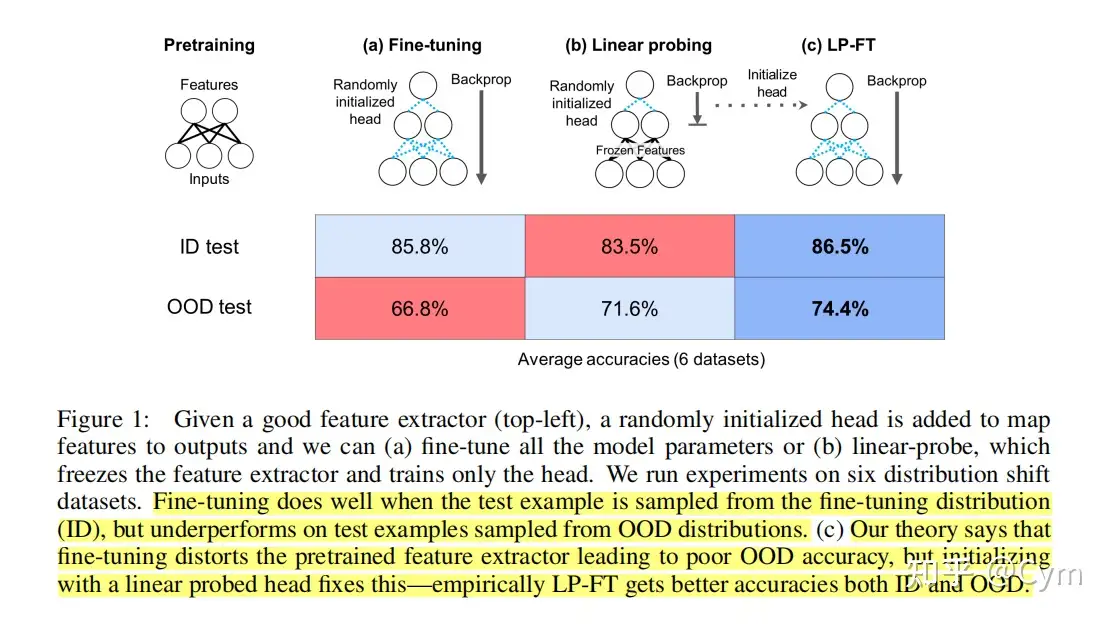

In [ ]:
chkpt = torch.load('lora_head.pt')
chkpt.keys()

odict_keys(['original_module.weight', 'modules_to_save.default.weight'])

In [ ]:
model = Model(tokenizer, num_classes).to(device)
model.model.score.load_state_dict({
    'weight': torch.load('lora_head.pt')['modules_to_save.default.weight']
})
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


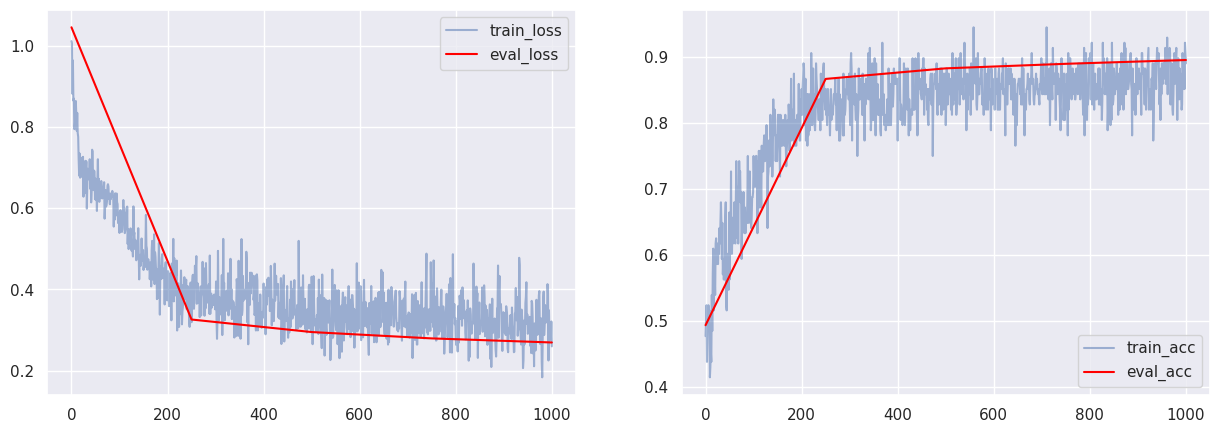

 56%|█████▌    | 218/391 [01:39<01:18,  2.19it/s]

CPU times: user 7min 25s, sys: 3.68 s, total: 7min 28s
Wall time: 7min 37s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2690844054615826
val accuracy: 0.8956422209739685


### Testing the model

In [ ]:
@torch.no_grad()
def predict(text, target=0):
    tokenized = tokenizer(text, return_tensors='pt')
    for k, v in tokenized.items():
        tokenized[k] = v.to(device)

    logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    predicted_class_id = int(torch.argmax(logits, dim=-1))
    print(f"text: {text}")
    print(f"target: {target}, pred: {predicted_class_id}")
    print("probs:", probs.cpu().numpy())

In [ ]:
predict("this movie is amaizing", 1)

text: this movie is amaizing
target: 1, pred: 0
probs: [[0.72263163 0.27736837]]


In [ ]:
for i in range(10):
    text = valid_dataset[i]["sentence"]
    label = valid_dataset[i]["label"]
    predict(text, label)
    print()

text: it 's a charming and often affecting journey . 
target: 1, pred: 1
probs: [[0.00352353 0.9964765 ]]

text: unflinchingly bleak and desperate 
target: 0, pred: 0
probs: [[0.9398412  0.06015881]]

text: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
target: 1, pred: 1
probs: [[0.03995326 0.9600467 ]]

text: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
target: 1, pred: 1
probs: [[0.02317043 0.9768296 ]]

text: it 's slow -- very , very slow . 
target: 0, pred: 0
probs: [[0.9705794  0.02942058]]

text: although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
target: 1, pred: 1
probs: [[0.0241132 0.9758868]]

text: a sometimes tedious film . 
target: 0, pred: 0
probs: [[0.9769846 0.0230154]]

text: or doing last year 's taxes with your ex-wife . 
target: 0, pred: 0
probs: [[0.90171987 0.09828009]]
